In [2]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_array, check_X_y

import japanize_matplotlib  # noqa
import matplotlib.pyplot as plt
import seaborn as sns  # データ可視化ライブラリ
from lightning.pytorch import seed_everything

from sklearn.decomposition import PCA
from scipy import stats
import pandas as pd
from sklearn.cluster import KMeans
from abc import ABCMeta, abstractmethod

from numpy.typing import NDArray

from typing import Optional

plt.style.use("ggplot")
seed_everything(8)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in

8

# データの前処理

In [3]:
# 外れ値の除去
def remove_outliers_zscore(data, metric, threshold=2):
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

In [33]:
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\オンラインデータ\NHANES_age_prediction.csv"
)
df1 = df1.drop(columns=["SEQN", "age_group"])

obj1 = "BMXBMI"
features_list1 = [
    "RIDAGEYR",  # 年齢（連続変数）
    "RIAGENDR",  # 性別（1:Male, 2:Female)
    "PAQ605",  # 運動有無(1:日常的に運動する, 2:運動しない)
    "LBXGLU",  # 断食後の血糖値（連続変数）
    "DIQ010",  # 糖尿病の有無(0:なし、1:あり)
    "LBXGLT",  # 口内の健康状態（連続変数）
    "LBXIN",  # 血中インスリン濃度（連続変数）
]
df1 = df1[df1["PAQ605"] != 7.0]

In [4]:
df2 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\オンラインデータ\OnlineNewsPopularity\OnlinenewsPopularity.csv"
)
df2 = df2.drop(columns=["url"])
df2 = df2.drop(columns=[" timedelta"])

obj2 = " shares"
features_list2 = [col for col in list(df2.columns) if col != " shares"]

In [5]:
df3 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\オンラインデータ\USCensus1990.data.txt",
    delimiter=",",
)

obj3 = "iFertil"
features_list3 = [col for col in list(df3.columns) if col != obj3]
features_list3_20 = features_list3[:20]
print(features_list3_20)

['caseid', 'dAge', 'dAncstry1', 'dAncstry2', 'iAvail', 'iCitizen', 'iClass', 'dDepart', 'iDisabl1', 'iDisabl2', 'iEnglish', 'iFeb55', 'dHispanic', 'dHour89', 'dHours', 'iImmigr', 'dIncome1', 'dIncome2', 'dIncome3', 'dIncome4']


In [36]:
df4 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)

obj4 = "GMV"
features_list4 = [
    "hist_4_day_buy_num",
    "hist_4_day_gmv",
    "his_4_day_is_buy",
    "hist_30_day_buy_days",
    "hist_30_day_buy_num",
    "hist_30_day_gmv",
    "hist_30_day_buy_recency",
    "hist_30_day_pay_days",
    "hist_30_day_atpu",
    "hist_30_day_gpv",
    "hist_30_day_pay_recency",
    "hist_30_day_list_days",
    "hist_30_day_list_num",
    "hist_30_day_list_recency",
    "hist_30_day_like_count",
    "hist_30_day_like_count_not_deleted",
    "hist_30_day_like_recency",
]

In [5]:
df = df2  # 選ぶ
obj = obj2  # 選ぶ
features_list = features_list2  # 選ぶ

df = remove_outliers_zscore(df, obj)

X = df[features_list]
# 数値列の標準化
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaled_features, columns=features_list)

y = df[obj]  # 目的変数

# 行を詰める
df = df.reset_index(drop=True)

# FSSEM でクラスタリング

Wrapperクラス

In [6]:
clusters = 5
n_features_to_select = 5  # 選択したい特徴量の数

In [7]:
class Wrapper(BaseEstimator, TransformerMixin):
    def __init__(self, n_features_to_select, n_clusters, random_state=None):
        self.n_features_to_select = n_features_to_select
        self.n_clusters = n_clusters
        self.random_state = random_state

    def FSSEM(self, X, y):
        X, y = check_X_y(X, y)

        n_features = X.shape[1]
        self.selected_features_ = []

        # Initialize current and remaining feature indices
        current_features = []
        remaining_features = list(range(n_features))

        # Cache GMM results to avoid redundant computations
        gmm_cache = {}

        while len(current_features) < self.n_features_to_select:
            print(current_features)
            best_score = -np.inf
            best_feature = None

            for feature in remaining_features:
                temp_features = tuple(current_features + [feature])

                if temp_features in gmm_cache:
                    score = gmm_cache[temp_features]
                else:
                    score = self.evaluate_subset(X[:, temp_features], y)
                    gmm_cache[temp_features] = score

                if score > best_score:
                    best_score = score
                    best_feature = feature

            if best_feature is not None:
                current_features.append(best_feature)
                remaining_features.remove(best_feature)
                self.selected_features_ = current_features
            else:
                break

        # Perform clustering with selected features
        final_features = X[:, self.selected_features_]
        self.final_gmm_ = GaussianMixture(
            n_components=self.n_clusters, random_state=self.random_state
        )
        self.final_gmm_.fit(final_features)
        self.final_cluster_assignments_ = self.final_gmm_.predict(final_features)

        return self

    #  #   def evaluate_subset(self, X_subset, y):
    #         gmm = GaussianMixture(
    #             n_components=self.n_clusters, random_state=self.random_state
    #         )
    #         gmm.fit(X_subset)

    #         means = gmm.means_
    #         covariances = gmm.covariances_
    #         weights = gmm.weights_
    #         overall_mean = np.sum(weights[:, np.newaxis] * means, axis=0)

    #         S_W = np.sum(weights[:, np.newaxis, np.newaxis] * covariances, axis=0)
    #         S_B = np.sum(
    #             weights[:, np.newaxis, np.newaxis]
    #             * np.einsum("...i,...j->...ij", means - overall_mean, means - overall_mean),
    #             axis=0,
    #         )
    # scatter_discriminability = np.trace(np.linalg.solve(S_W, S_B))
    # return scatter_discriminability

    def evaluate_subset(self, X_subset, y):
        gmm = GaussianMixture(
            n_components=self.n_clusters, random_state=self.random_state
        )
        gmm.fit(X_subset)

        # 対数尤度を計算し、評価スコアとして使用
        log_likelihood = gmm.score(X_subset)
        return log_likelihood

    def transform(self, X):
        check_array(X)
        return X[:, self.selected_features_]

    def get_feature_index_out(self):
        return np.array(self.selected_features_)

    def get_final_cluster_assignments(self):
        return self.final_cluster_assignments_

Wrapperクラス確認

In [8]:
# import warnings
# from sklearn.exceptions import ConvergenceWarning

# warnings.filterwarnings("ignore", category=ConvergenceWarning)

fssem = Wrapper(
    n_features_to_select=n_features_to_select, n_clusters=clusters, random_state=0
)

# FSSEM
fssem.FSSEM(X_scaled, y)  # 選択された特徴量
selected_features = fssem.get_feature_index_out()
print(f"Selected features indices: {selected_features}")

print("選択された特徴量")
for n in selected_features:
    print(X_scaled.columns[n])

FSSEM_cluster = fssem.get_final_cluster_assignments()
cluster_size = np.unique(FSSEM_cluster, return_counts=True)

print(FSSEM_cluster)

[]


c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Po

[3]
[3, 11]
[3, 11, 14]
[3, 11, 14, 15]
Selected features indices: [ 3 11 14 15  2]
選択された特徴量
 n_non_stop_words
 data_channel_is_lifestyle
 data_channel_is_socmed
 data_channel_is_tech
 n_unique_tokens
[0 0 0 ... 0 0 0]


FSSEM のクラスタリング結果

Text(0, 0.5, 'y')

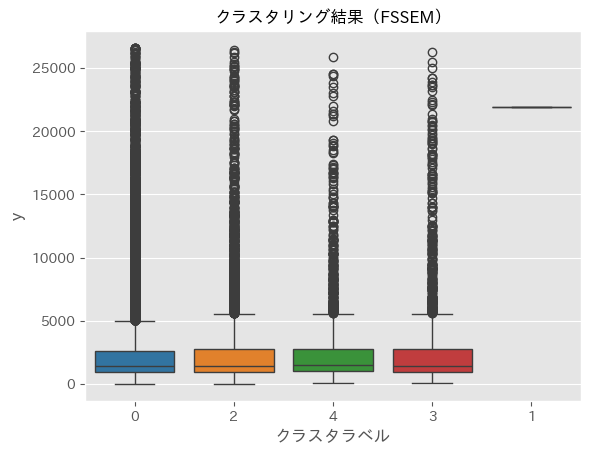

In [9]:
X_with_clusterlabelrow = X_scaled.copy()
X_with_clusterlabelrow["FSSEM_cluster"] = FSSEM_cluster


# 目的変数の分布
sns.boxplot(  # 箱ひげ図
    x=X_with_clusterlabelrow["FSSEM_cluster"].astype(
        str
    ),  # x軸、as.type(str)で文字列に変換
    y=y,  # y軸
    hue=X_with_clusterlabelrow["FSSEM_cluster"].astype(
        str
    ),  # クラスタラベルに基づいて色を付ける
    palette="tab10",  # カラーパレット指定
    legend=False,
)
plt.title("クラスタリング結果（FSSEM）", fontdict={"fontsize": "large"})
plt.xlabel("クラスタラベル")
plt.ylabel("y")